In [10]:
import pandas as pd
import random

df = pd.read_csv('../csv/all_char_archetypes.csv')

archetypes = df['campbell_archetype'].unique()

char_list = df[['play', 'character']].copy()

random.seed(42)
char_list['campbell_archetype'] = [random.choice(archetypes) for _ in range(len(char_list))]

char_list.to_csv('../csv/random_char_archetypes.csv', index=False)
print("Saved random archetype assignments!")



Saved random archetype assignments!


Random Model Accuracy: 0.116
Random Model Macro F1: 0.087

Classification Report:

              precision    recall  f1-score   support

           0      0.333     0.152     0.209       105
           1      0.194     0.084     0.118        83
           2      0.062     0.100     0.077        20
           3      0.000     0.000     0.000         8
           4      0.067     0.125     0.087        16
           5      0.000     0.000     0.000        11
           6      0.079     0.136     0.100        22
           7      0.082     0.138     0.103        29

    accuracy                          0.116       294
   macro avg      0.102     0.092     0.087       294
weighted avg      0.196     0.116     0.135       294

Random Model Macro ROC AUC: 0.482


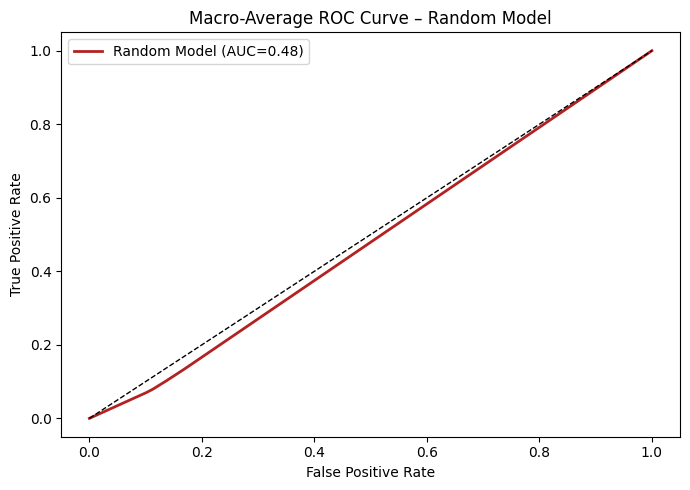

In [11]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Load the true archetypes and the random assignments ---
true_df = pd.read_csv('../csv/all_char_archetypes.csv')
rand_df = pd.read_csv('../csv/random_char_archetypes.csv')

# Merge on play + character to align rows
merged = pd.merge(true_df, rand_df, on=['play', 'character'], how='inner', suffixes=('_true', '_pred'))

# Encode labels for evaluation
le = LabelEncoder()
y_true = le.fit_transform(merged['campbell_archetype_true'])
y_pred = le.transform(merged['campbell_archetype_pred'])

# --- Metrics ---
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
accuracy = (y_true == y_pred).mean()
print(f"Random Model Accuracy: {accuracy:.3f}")
print(f"Random Model Macro F1: {f1:.3f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))

# --- Multi-class ROC AUC ---
# Binarize for ROC (if at least 2 classes exist)
y_true_bin = label_binarize(y_true, classes=range(len(le.classes_)))
y_pred_bin = label_binarize(y_pred, classes=range(len(le.classes_)))
if y_true_bin.shape[1] > 1:
    auc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
    print(f"Random Model Macro ROC AUC: {auc_macro:.3f}")

    # Macro-average ROC curve
    fpr_dict, tpr_dict = {}, {}
    for i in range(len(le.classes_)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        fpr_dict[i], tpr_dict[i] = fpr, tpr
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in fpr_dict]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in fpr_dict:
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= len(fpr_dict)
    macro_auc = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(7,5))
    plt.plot(all_fpr, mean_tpr, lw=2, color='firebrick',
             label=f"Random Model (AUC={macro_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-Average ROC Curve – Random Model')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough classes to compute ROC AUC.")

